In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [2]:
import cv2 as cv
from dataclasses import dataclass
from pathlib import Path
import requests
from tqdm.notebook import tqdm

@dataclass
class ImageInfo:
    image_path: Path
    url: str
    img: cv.Mat|None = None

    def download(self) -> cv.Mat:
        headers = {'User-Agent': 'ComputerVisionExperiments/0.0 (https://github.com/seafoodfry/ml-workspace/tree/main/gpu-sandbox/vision)'}
        response = requests.get(self.url, headers=headers)
        response.raise_for_status()

        img_data = response.content
        with open(self.image_path, 'wb') as f:
            f.write(img_data)
    
        # Opencv reads images in BGR.
        self.img = cv.imread(self.image_path, cv.IMREAD_UNCHANGED)

    def rgb(self) -> cv.Mat:
        return cv.cvtColor(self.img, cv.COLOR_BGR2RGB)


class ImageCache:
    def __init__(self, base_path: str = './img/004-images'):
        self._base_path = Path(base_path)
        self._base_path.mkdir(parents=True, exist_ok=True)
        
        self._cache: dict[str, ImageInfo] = {
            'scroll': ImageInfo( # https://www.historyextra.com/period/ancient-egypt/egyptian-hieroglyphs-facts/
                image_path=self._base_path / 'scroll.jpg',
                url='https://images.immediate.co.uk/production/volatile/sites/7/2022/09/GettyImages-1268642237-9d510a8-e1664288836115.jpg?quality=90&webp=true&resize=2250,1501',
            )
        }
        for img_key, img in tqdm(self._cache.items(), desc="Downloading images"):
            img.download()

    def images(self):
        """Return all the image names registered."""
        return self._cache.keys()

    def __getitem__(self, img_name: str) -> ImageInfo:
        """Allow dictionary-like access to loaded images."""
        if img_name not in self._cache:
            self.load_img(img_name)
        return self._cache[img_name]

    def cwd(self):
        return self._base_path


CACHE = ImageCache()

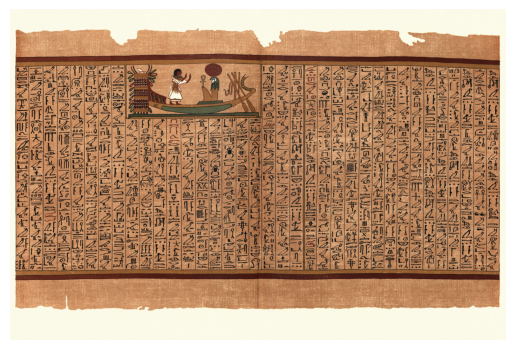

In [3]:
plt.imshow(CACHE['scroll'].rgb())
plt.axis('off')    
plt.show()

In [4]:
CACHE['scroll'].img.shape

(1501, 2250, 3)

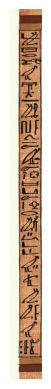

In [5]:
plt.imshow(CACHE['scroll'].rgb()[200:1250, 0:90])
plt.axis('off')    
plt.show()

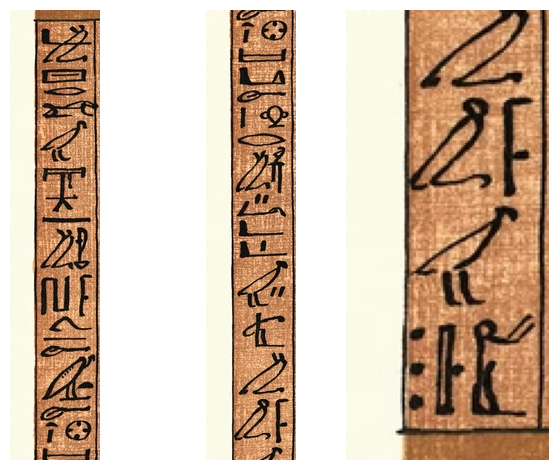

In [6]:
plt.subplot(1, 3, 1)
plt.imshow(CACHE['scroll'].rgb()[250:700, 0:90])
plt.axis('off')  

plt.subplot(1, 3, 2)
plt.imshow(CACHE['scroll'].rgb()[650:1_100, 0:90])
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(CACHE['scroll'].rgb()[1_000:1_200, 0:90])
plt.axis('off')

plt.tight_layout()
plt.show()

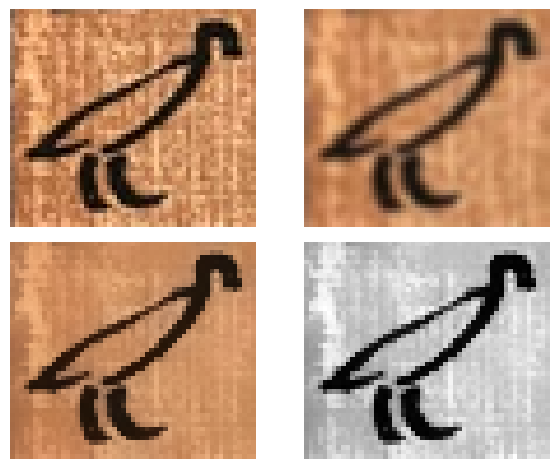

In [7]:
template = CACHE['scroll'].img[358:405, 27:80]
template_rgb = cv.cvtColor(template, cv.COLOR_BGR2RGB)

template_gaussian_filtered = cv.GaussianBlur(template, (3,3), 0)
template_bilateral_filtered = cv.bilateralFilter(template, 9, 91, 91)

plt.subplot(2, 2, 1)
plt.imshow(template_rgb)
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(cv.cvtColor(template_gaussian_filtered, cv.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(cv.cvtColor(template_bilateral_filtered, cv.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(cv.cvtColor(template_bilateral_filtered, cv.COLOR_BGR2GRAY), cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

In [20]:
# Make it gray and normalize the pixel values to [0,1].
gray_img = cv.cvtColor(CACHE['scroll'].img, cv.COLOR_BGR2GRAY)
gray_norm = cv.normalize(gray_img, None, 0, 1, cv.NORM_MINMAX, cv.CV_64F)


sobelX = cv.Sobel(gray_norm, cv.CV_64F, 1, 0, borderType=cv.BORDER_DEFAULT)
sobelY = cv.Sobel(gray_norm, cv.CV_64F, 0, 1, borderType=cv.BORDER_DEFAULT)


#sobel_magnitude = cv.normalize(cv.bitwise_or(
#    np.absolute(sobelX).astype(np.uint8),
#    np.absolute(sobelY).astype(np.uint8),
#), None, 0, 255, cv.NORM_MINMAX, dtype=cv.CV_8U)

In [28]:
# Docs on normalize
# https://docs.opencv.org/4.x/d2/de8/group__core__array.html#ga7bcf47a1df78cf575162e0aed44960cb
#
# Note that in some older literature/examples, ppl may add 4 to each partial derivative and divide by 8.
# This is because the sobel filter will at most result in a max abs magnitude of 4 along a direction.
# And we divide by 8 because we do this twice.
# But the following is more robust and less "what? why?".
normalized_sobelX = cv.normalize(np.absolute(sobelX), None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)
normalized_sobelY = cv.normalize(np.absolute(sobelY), None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)

"""
NOTE: if you want to combine the derivatives using the bitwise op then the arguments
must be made up of integers!
Having an image normalized on [0, 1] will NOT work!
"""
#normalized_sobelX = cv.normalize(np.absolute(sobelX), None, 0, 1, cv.NORM_MINMAX, cv.CV_64F)
#normalized_sobelY = cv.normalize(np.absolute(sobelY), None, 0, 1, cv.NORM_MINMAX, cv.CV_64F)
normalized_sobel = cv.bitwise_or(normalized_sobelX, normalized_sobelY)

In [29]:
np.min(normalized_sobel), np.max(normalized_sobel)

(np.uint8(0), np.uint8(255))

In [33]:
bins = np.linspace(np.min(normalized_sobel), np.max(normalized_sobel), 10)
hist_counts, bin_edges = np.histogram(normalized_sobel, bins=bins)

for i in range(len(hist_counts)):
    values_range = f"{bin_edges[i]:>7.1f} to {bin_edges[i+1]:>7.1f}"
    count = f"{hist_counts[i]:>8_}"
    percentage = (hist_counts[i] / normalized_sobel.size) * 100
    print(f"Values {values_range}: {count} ({percentage:>5.2f}%)")

Values     0.0 to    28.3: 2_008_224 (59.46%)
Values    28.3 to    56.7:  630_109 (18.66%)
Values    56.7 to    85.0:  206_004 ( 6.10%)
Values    85.0 to   113.3:  157_897 ( 4.68%)
Values   113.3 to   141.7:  183_537 ( 5.43%)
Values   141.7 to   170.0:  103_434 ( 3.06%)
Values   170.0 to   198.3:   64_332 ( 1.90%)
Values   198.3 to   226.7:   16_026 ( 0.47%)
Values   226.7 to   255.0:    7_687 ( 0.23%)


In [34]:
@dataclass
class ROI:
    """
    i for initial
    f for final
    """
    x_i: int
    x_f: int
    y_i: int
    y_f: int

    def slice(self, img: np.ndarray):
        print(f'selecting the area {self.y_i}:{self.y_f}, {self.x_i}:{self.x_f}')
        return img[self.y_i:self.y_f, self.x_i:self.x_f]

    def slice_to_rgb(self, img: np.ndarray):
        return cv.cvtColor( self.slice(img), cv.COLOR_BGR2RGB)

selecting the area 250:700, 0:90
selecting the area 250:700, 0:90
selecting the area 250:700, 0:90
selecting the area 250:700, 0:90


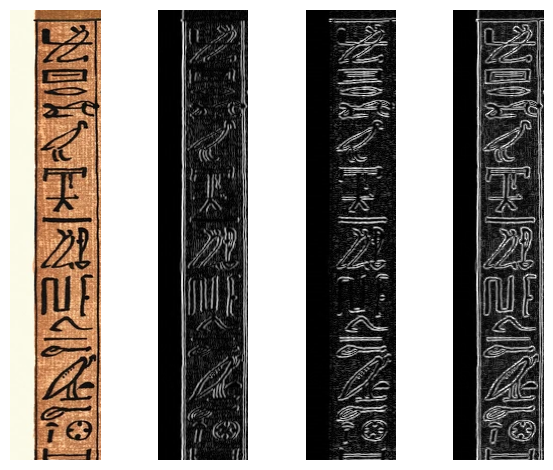

In [35]:
# This is the first strip we identified above.
roi = ROI(0, 90, 250, 700)

plt.subplot(1, 4, 1)
plt.imshow( roi.slice(CACHE['scroll'].rgb()) )
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow( roi.slice(normalized_sobelX), cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow( roi.slice(normalized_sobelY), cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow( roi.slice(normalized_sobel), cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

# Sobel Again: Gaussian blur + diff way of obtaining magnitudes

This follows https://docs.opencv.org/4.x/d2/d2c/tutorial_sobel_derivatives.html more closely.

In [37]:
gray_img = cv.cvtColor(CACHE['scroll'].img, cv.COLOR_BGR2GRAY)
gray_with_blur = cv.GaussianBlur(gray_img, (3, 3), 0)
gray_norm = cv.normalize(gray_with_blur, None, 0, 1, cv.NORM_MINMAX, cv.CV_64F)

sobelX = cv.Sobel(gray_norm, cv.CV_64F, 1, 0, borderType=cv.BORDER_DEFAULT)
sobelY = cv.Sobel(gray_norm, cv.CV_64F, 0, 1, borderType=cv.BORDER_DEFAULT)

"""
The following is aok IFF the input image is the standard [0, 255] range.
"""
# For each element in the array, cv.convertScaleAbs does these operations in order:
# 1. Multiply by alpha (scaling factor)
# 2. Add beta (offset)
# 3. Take absolute value 
# 4. Convert to uint8 (clips to 0-255 range)
#abs_grad_x = cv.convertScaleAbs(sobelX)
#abs_grad_y = cv.convertScaleAbs(sobelY)
#grad = cv.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)

# Calculate gradient magnitude and normalize to [0, 1].
gradient_magnitude = np.sqrt(np.square(sobelX) + np.square(sobelY))
normalized_gradient = cv.normalize(gradient_magnitude, None, 0, 1, cv.NORM_MINMAX, cv.CV_64F)

# For visualization (scale to [0, 255]).
visualization_x = cv.normalize(np.absolute(sobelX), None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)
visualization_y = cv.normalize(np.absolute(sobelY), None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)
visualization_magnitude = cv.normalize(normalized_gradient, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)

selecting the area 250:700, 0:90
selecting the area 250:700, 0:90
selecting the area 250:700, 0:90
selecting the area 250:700, 0:90


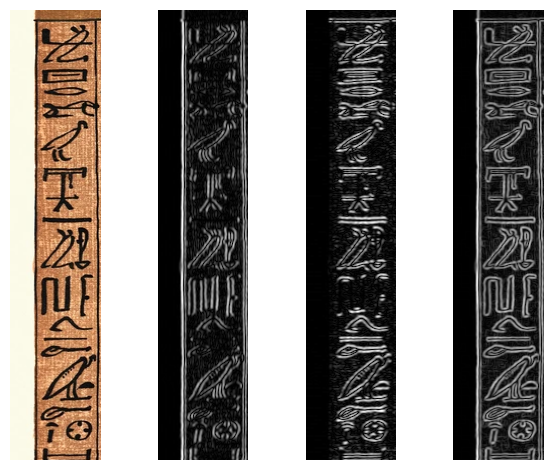

In [38]:
plt.subplot(1, 4, 1)
plt.imshow( roi.slice(CACHE['scroll'].rgb()) )
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow( roi.slice(visualization_x), cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow( roi.slice(visualization_y), cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow( roi.slice(visualization_magnitude), cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

selecting the area 250:700, 0:90
selecting the area 250:700, 0:90
selecting the area 250:700, 0:90
selecting the area 250:700, 0:90


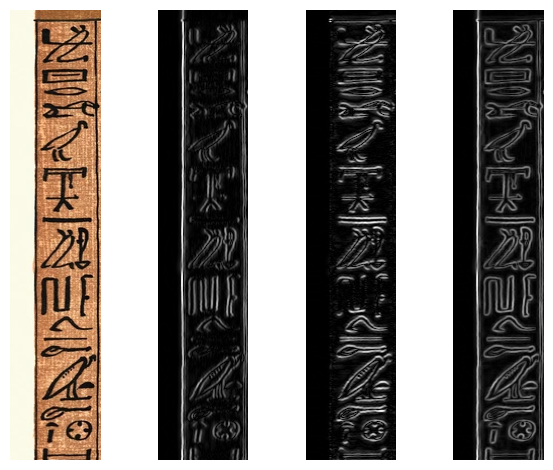

In [41]:
# Witha bilateral blur now.
gray_img = cv.cvtColor(CACHE['scroll'].img, cv.COLOR_BGR2GRAY)
gray_with_blur = cv.bilateralFilter(gray_img, 9, 91, 91)
gray_norm = cv.normalize(gray_with_blur, None, 0, 1, cv.NORM_MINMAX, cv.CV_64F)

sobelX = cv.Sobel(gray_norm, cv.CV_64F, 1, 0, borderType=cv.BORDER_DEFAULT)
sobelY = cv.Sobel(gray_norm, cv.CV_64F, 0, 1, borderType=cv.BORDER_DEFAULT)

# Calculate gradient magnitude and normalize to [0, 1].
gradient_magnitude = np.sqrt(np.square(sobelX) + np.square(sobelY))
normalized_gradient = cv.normalize(gradient_magnitude, None, 0, 1, cv.NORM_MINMAX, cv.CV_64F)

# For visualization (scale to [0, 255]).
visualization_x = cv.normalize(np.absolute(sobelX), None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)
visualization_y = cv.normalize(np.absolute(sobelY), None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)
visualization_magnitude = cv.normalize(normalized_gradient, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)


plt.subplot(1, 4, 1)
plt.imshow( roi.slice(CACHE['scroll'].rgb()) )
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow( roi.slice(visualization_x), cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow( roi.slice(visualization_y), cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow( roi.slice(visualization_magnitude), cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

# Again but with proper maths

Thus far we've been normalizing the images for displays, and the normalization has been a tad off.
The "proper" normalization would be to use $\sqrt{G_{x}^{2} + G_{y}^{2}}$ and then dive by a factor of
$\sqrt{4^2 + 4^2} = 4\sqrt{2}$.
This normalization factor comes from the maximum possible response of the Sobel filter.

```
Gx = [[-1, 0, 1],      Gy = [[-1, -2, -1],
      [-2, 0, 2],            [0,  0,  0],
      [-1, 0, 1]]            [1,  2,  1]]
```

The maximum response occurs when:

1. For Gx: You have maximum difference across horizontal direction
1. For Gy: You have maximum difference across vertical direction
1. Due to the kernel weights, the maximum response for each direction is 4 (sum of absolute weights in each direction)

When you combine both directions using the Euclidean norm, the maximum possible magnitude would be
$\sqrt{4^2 + 4^2} = 4\sqrt{2}$

min grad val: 0.0. max grad val: 0.514481052957795
min grad val: 0.0. max grad val: 1.0
selecting the area 250:700, 0:90
selecting the area 250:700, 0:90


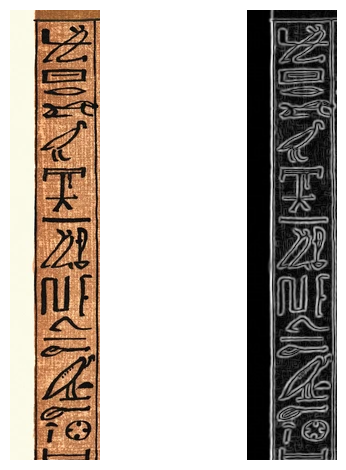

In [44]:
gray_img = cv.cvtColor(CACHE['scroll'].img, cv.COLOR_BGR2GRAY)
gray_with_blur = cv.GaussianBlur(gray_img, (3, 3), 0)
gray_norm = cv.normalize(gray_with_blur, None, 0, 1, cv.NORM_MINMAX, cv.CV_64F)


sobelX = cv.Sobel(gray_norm, cv.CV_64F, 1, 0, borderType=cv.BORDER_DEFAULT)
sobelY = cv.Sobel(gray_norm, cv.CV_64F, 0, 1, borderType=cv.BORDER_DEFAULT)

grad = np.sqrt(np.square(sobelX) + np.square(sobelY))
grad = grad / (4 * np.sqrt(2))
print(f'min grad val: {np.min(grad)}. max grad val: {np.max(grad)}')

# Normalize to [0,1] before plotting - gradients can still be above 1.
# TThe division by 4√2 gives us the "true" normalized gradient values relative to what's
# theoretically possible with the Sobel kernels. However, for most practical applications
# (especially visualization and ML), we care more about the relative differences between
# gradients in this specific image.
grad_normalized = grad / grad.max()
print(f'min grad val: {np.min(grad_normalized)}. max grad val: {np.max(grad_normalized)}')


plt.subplot(1, 2, 1)
plt.imshow( roi.slice(CACHE['scroll'].rgb()) )
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow( roi.slice( grad_normalized ), cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

# Directions

magnitude_mask shape: (1501, 2250)
magnitude_mask dtype: uint8
selecting the area 250:700, 0:90
selecting the area 250:700, 0:90


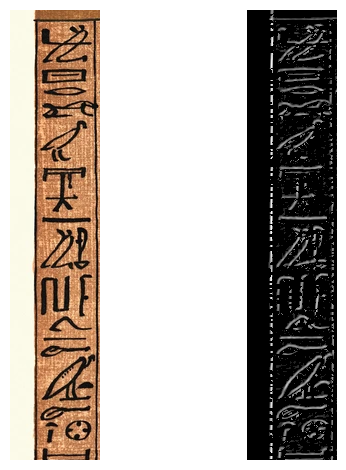

In [89]:
# Edges are primarily about intensity changes, not color changes.
# There are some specialized cases where you might want per-channel gradients
# (like detecting edges in specific color transitions), but for general edge detection, grayscale is the way to go!
# If we don't do this, then the gradient will be a 3 channel array.
gray_img = cv.cvtColor(CACHE['scroll'].img, cv.COLOR_BGR2GRAY)
gray_with_blur = cv.GaussianBlur(gray_img, (3, 3), 0)
gray_norm = cv.normalize(gray_with_blur, None, 0, 1, cv.NORM_MINMAX, cv.CV_64F)


sobelX = cv.Sobel(gray_norm, cv.CV_64F, 1, 0, borderType=cv.BORDER_DEFAULT)
sobelY = cv.Sobel(gray_norm, cv.CV_64F, 0, 1, borderType=cv.BORDER_DEFAULT)

grad = np.sqrt(np.square(sobelX) + np.square(sobelY))
grad = grad / (4 * np.sqrt(2))

# Normalize to [0,1] before plotting - gradients can still be above 1.
grad_normalized = grad / grad.max()

# Compute the directions.
# Use -sobelY if you want the increasing direction to be clockwise.
theta = np.arctan2(sobelY, sobelX)
# Convert to degrees - this is the same as theta * 180 / np.pi.
theta_deg = np.rad2deg(theta)



# Apply an "intensity threshold" (rememebr back in 003 how we applied
# a threshold to finetune the template matches? that's a good pattern here too).
grad_threshold = 0.1
# create a binary mask where values above threshold become 255 (white)
# Note that we could use 1 and to keep our "containerrs" normalized in the range [0, 1].
# But, since we will be doing bitwise operations we will go back to the [0, 255] range.
magnitude_mask = np.uint8((grad_normalized > grad_threshold) * 255)
# If magnitude_mask is still 3-channel, take just one channel:
#if len(magnitude_mask.shape) == 3:
#    magnitude_mask = magnitude_mask[:,:,0]
print("magnitude_mask shape:", magnitude_mask.shape)
print("magnitude_mask dtype:", magnitude_mask.dtype)

# The four quadrants for 45-60 degrees are:
# Quadrant 1: 45 to 60
# Quadrant 2: 120 to 135 (180 - 60 to 180 - 45)
# Quadrant 3: -135 to -120 (-180 + 45 to -180 + 60)
# Quadrant 4: -60 to -45
#
# Create masks for each quadrant
q1_mask = cv.inRange(theta_deg, 45, 60)
q2_mask = cv.inRange(theta_deg, 120, 135)
q3_mask = cv.inRange(theta_deg, -180, -60)
q4_mask = cv.inRange(theta_deg, -60, -45)
angle_mask = cv.bitwise_or(
    cv.bitwise_or(q1_mask, q2_mask),
    cv.bitwise_or(q3_mask, q4_mask)
)

# Combine the masks.
final_mask = cv.bitwise_and(angle_mask, magnitude_mask)

# You can then use this mask to get your pixels of interest.
#pixels_of_interest = grad[final_mask > 0] doesn't preserve the shape.
pixels_of_interest = grad_normalized * (final_mask > 0)  # Hadamard product.

plt.subplot(1, 2, 1)
plt.imshow( roi.slice(CACHE['scroll'].rgb()) )
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow( roi.slice( pixels_of_interest ), cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

In [90]:
bins = np.linspace(-180, 181, 10)  # Creates bins [-180, -160, ..., 160, 180]
hist_counts, bin_edges = np.histogram(theta_deg.ravel(), bins=bins)

for i in range(len(hist_counts)):
    angle_range = f"{bin_edges[i]:>7.1f}° to {bin_edges[i+1]:>7.1f}°"
    count = f"{hist_counts[i]:>8_}"
    percentage = (hist_counts[i] / theta_deg.size) * 100
    print(f"Angles {angle_range}: {count} ({percentage:>5.2f}%)")

Angles  -180.0° to  -139.9°:  332_252 ( 9.84%)
Angles  -139.9° to   -99.8°:  288_504 ( 8.54%)
Angles   -99.8° to   -59.7°:  356_966 (10.57%)
Angles   -59.7° to   -19.6°:  255_200 ( 7.56%)
Angles   -19.6° to    20.6°:  863_397 (25.57%)
Angles    20.6° to    60.7°:  279_921 ( 8.29%)
Angles    60.7° to   100.8°:  384_934 (11.40%)
Angles   100.8° to   140.9°:  256_347 ( 7.59%)
Angles   140.9° to   181.0°:  359_729 (10.65%)


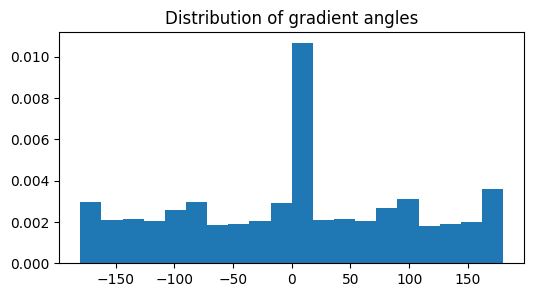

In [91]:
plt.figure(figsize=(6,3))
plt.hist(theta_deg.ravel(), density=True, bins=20)
plt.title('Distribution of gradient angles')
plt.show()

In [93]:
bins = np.linspace(np.min(grad_normalized), np.max(grad_normalized), 10)
hist_counts, bin_edges = np.histogram(grad_normalized, bins=bins)

for i in range(len(hist_counts)):
    values_range = f"{bin_edges[i]:>7.1f} to {bin_edges[i+1]:>7.1f}"
    count = f"{hist_counts[i]:>8_}"
    percentage = (hist_counts[i] / grad_normalized.size) * 100
    print(f"Values {values_range}: {count} ({percentage:>5.2f}%)")

Values     0.0 to     0.1: 2_195_492 (65.01%)
Values     0.1 to     0.2:  428_527 (12.69%)
Values     0.2 to     0.3:  218_279 ( 6.46%)
Values     0.3 to     0.4:  215_614 ( 6.38%)
Values     0.4 to     0.6:  218_802 ( 6.48%)
Values     0.6 to     0.7:   90_135 ( 2.67%)
Values     0.7 to     0.8:    8_567 ( 0.25%)
Values     0.8 to     0.9:    1_332 ( 0.04%)
Values     0.9 to     1.0:      502 ( 0.01%)


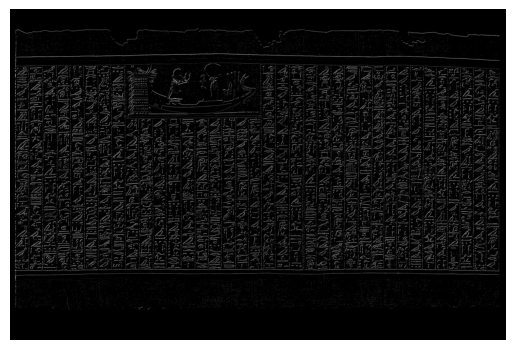

In [94]:
plt.imshow(pixels_of_interest, cmap='gray')
plt.axis('off')
plt.show()

In [95]:
print(f'Angle mask unique values: {np.unique(angle_mask)}')
print(f'Magnitude mask unique values: {np.unique(magnitude_mask)}')
print(f'Final mask unique values: {np.unique(final_mask)}')
print(f'Percentage of non-zero pixels in angle mask: {(angle_mask > 0).mean() * 100: 0.3f} %')
print(f'Percentage of non-zero pixels in magnitude mask: {(magnitude_mask > 0).mean() * 100: 0.3f} %')
print(f'Percentage of non-zero pixels in final mask: {(final_mask > 0).mean() * 100: 0.3f}%')

Angle mask unique values: [  0 255]
Magnitude mask unique values: [  0 255]
Final mask unique values: [  0 255]
Percentage of non-zero pixels in angle mask:  37.579 %
Percentage of non-zero pixels in magnitude mask:  37.933 %
Percentage of non-zero pixels in final mask:  16.085%


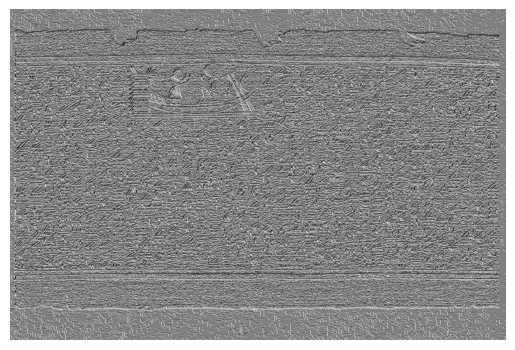

In [96]:
plt.imshow( theta_deg, cmap='gray')
plt.axis('off')
plt.show()

In [97]:
print(f'Final mask min/max: {final_mask.min()}, {final_mask.max()}')
print(f'Number of non-zero pixels in final mask: {np.count_nonzero(final_mask):_}')
print(f'Percentage of non-zero pixels in final mask: {(np.count_nonzero(final_mask) / final_mask.size) *100: 0.3f}')

Final mask min/max: 0, 255
Number of non-zero pixels in final mask: 543_221
Percentage of non-zero pixels in final mask:  16.085


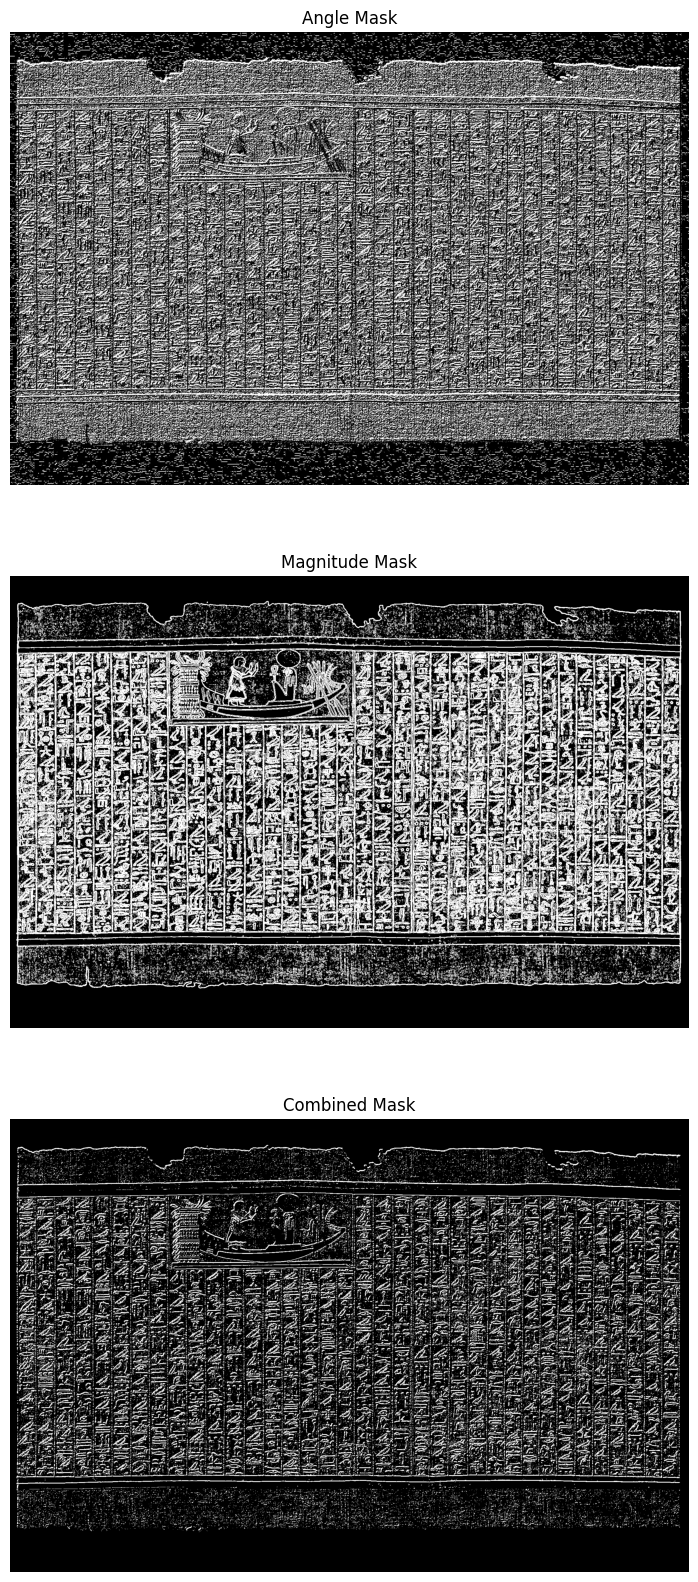

In [98]:
plt.figure(figsize=(15,20))

plt.subplot(311)
plt.imshow(angle_mask, cmap='gray')
plt.title('Angle Mask')
plt.axis('off')

plt.subplot(312)
plt.imshow(magnitude_mask, cmap='gray')
plt.title('Magnitude Mask')
plt.axis('off')

plt.subplot(313)
plt.imshow(final_mask, cmap='gray')
plt.title('Combined Mask')
plt.axis('off')

plt.show()